In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
def normalize_img(image, label):
  """Normalize images to float32"""
  return tf.cast(image, tf.float32) / 255., label

In [4]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
])

In [42]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [43]:
model.compile(
    loss=loss_obj,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [44]:
model.fit(x_train, y_train, epochs=6,)

Epoch 1/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0305 - accuracy: 0.9903
Epoch 2/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0233 - accuracy: 0.9927
Epoch 3/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0184 - accuracy: 0.9942
Epoch 4/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0152 - accuracy: 0.9953
Epoch 5/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0129 - accuracy: 0.9959
Epoch 6/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0125 - accuracy: 0.9959


In [45]:
def adversarial_example(image, label):
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = loss_obj(label, prediction)

  gradient = tape.gradient(loss, image)
  signed_grad = tf.sign(gradient)

  return signed_grad

In [61]:
image = x_test[0]
label = y_test[0]

In [62]:
perturbations = adversarial_example(tf.convert_to_tensor(image.reshape(1, img_rows, img_cols)), label).numpy()

In [63]:
perturbations.shape

(1, 28, 28)

In [64]:
perturbations[0].shape

(28, 28)

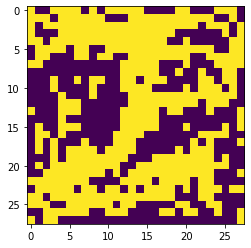

In [65]:
plt.imshow(perturbations[0]*0.5 + 0.5)

In [72]:
adx = image + 0.1 * perturbations

In [73]:
adx.shape

(1, 28, 28)

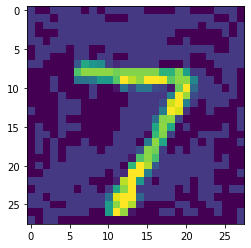

In [74]:
plt.imshow(adx[0])